In [15]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
#from keras.layers.core import MaxoutDense
from models.maxout_layers import Maxout1D

#dropout_enable = False

#model_file = "DL1_AntiKt4EMTopo_dropout" if dropout_enable else "DL1_AntiKt4EMTopo"

model = tf.keras.models.load_model("DL1_AntiKt4EMTopo")
model_dropout = tf.keras.models.load_model("DL1_AntiKt4EMTopo_dropout")
#test_model.summary()

import h5py
#get test dataset
hf = h5py.File("../FTAGUQ/input/MC16_ttbar-test-ujets.h5", 'r')
X_test, Y_test = hf['X_test'][:], hf['Y_test'][:]
hf.close()

 ## test two models 
 
1. with drop out.
2. without dropout.

In [29]:
re_dropout = model_dropout(np.array(10000*[X_test[9]]), training=False)

#no dropout
re = model(X_test, training=False)

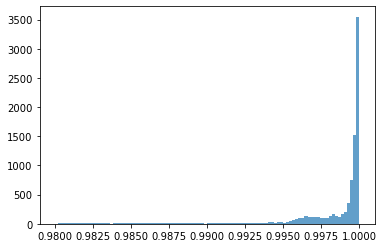

In [34]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the histogram of the data
n, bins, patches = ax.hist(re_dropout.numpy()[:,0], 100,range=(0.98,1.0), alpha=0.7)
#n, bins, patches =ax.hist(re.numpy()[:,0],100, alpha=0.3, color='red')

In [35]:
def DL1_socre(softmax_prob): 
    return np.log(softmax_prob[:,2]/(0.08*softmax_prob[:,1] + 0.92*softmax_prob[:,0]))  

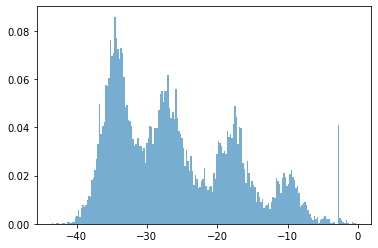

In [36]:
_ =plt.hist(DL1_socre(re_dropout.numpy()), 200,  density=True, alpha=0.6)

In [20]:
np.sum(DL1_socre(re.numpy())>1.45)/len(re.numpy()[:,0])

0.00914

In [21]:
DL1_socre(re.numpy())

array([-23.851442, -23.085033, -24.327097, ..., -22.967031, -23.655523,
       -23.32101 ], dtype=float32)